# Feature Engineering for the House Price Model pipeline

This notebook will handle Feature Engineering. Here. we'll tackle the following:

1. Missing values
2. Non-Gaussian distributed features
3. Categorical Features: Removing the rare labels
4. Ctegorical Features: convert strings to numbers
5. Handling Multicollinearity
6. Scaling the dataframe

Now, we proceed to import the packages

In [1]:
# Import Packages
# To handle datasets
import numpy as np
import pandas as pd

# for plotting visuals
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# For splitting dataset
from sklearn.model_selection import train_test_split

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# To save the trained scaler class
import joblib

# To visualize all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(14448, 16)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,age_group,income_bracket,rooms_per_household,bedrooms_per_household,population_per_household,median_income_per_household
0,-118.02,33.93,35.0,2400.0,398.0,1218.0,408.0,4.1312,193800.0,<1H OCEAN,middle-aged,low-income,6.0,1.0,3.0,0.010125
1,-117.09,32.79,20.0,2183.0,534.0,999.0,496.0,2.8631,169700.0,NEAR OCEAN,young,low-income,4.0,1.0,2.0,0.005772
2,-120.14,34.59,24.0,1601.0,282.0,731.0,285.0,4.2026,259800.0,NEAR OCEAN,young,low-income,6.0,1.0,3.0,0.014746
3,-121.00,39.26,14.0,810.0,151.0,302.0,138.0,3.1094,136100.0,INLAND,minor,low-income,6.0,1.0,2.0,0.022532
4,-122.45,37.77,52.0,3188.0,708.0,1526.0,664.0,3.3068,500001.0,NEAR BAY,elderly,low-income,5.0,1.0,2.0,0.004980


## Separate dataset into train and test sets

When engineering features, some techniques learn parameters from data. it is important to learn these parameters from the train set, in order to avoid overfitting.

Typically, our feature engineering techniques will learn things like mean, mode, exponents of the yeo-johnson transformation, frequencies of cayegory, and caegory to number mappings from the train set

### Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [3]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['total_bedrooms', 'households', 'age_group', 'median_house_value'], axis=1), # predictive variables
    data['median_house_value'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((13003, 12), (1445, 12))

## Feature Engineering

We're going to embark on the core Feature Engineering Tasks in order to tacke:

    Missing Values
    Temporal Values
    Non-Gaussian distributed values
    Categorical features: remove rare labels, if any
    Categorical Features: convert strings to numbers
    Put the variables in a similar scale
    
### Target/ Label

We apply the Yeo-Johnson transformation to the target variable

In [4]:
y_train = pd.Series(stats.yeojohnson(y_train)[0], name='median_house_value')
y_test = pd.Series(stats.yeojohnson(y_test)[0], name='median_house_value')

In [5]:
y_train.head()

0    30.324818
1    23.846476
2    30.324818
3    30.324818
4    24.894438
Name: median_house_value, dtype: float64

### Missing Values

#### Categorical Features

Replacing missing values with the string "missing" in those variables with missing data. Alternatively, we will replace missing data with the most frequent category in those variables which contain fewer observations without values.

In [6]:
# let's identify the categorical variables
# we will capture those of type object
# remove age_group, because it is not in the training dataset
cat_vars = [var for var in data.columns if data[var].dtype == 'O' and var != 'age_group']

# number of categorical variables
len(cat_vars)

2

In [7]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

This confirms that there are no null values in the dataframe, in this case. We leave this in, because we might encounter such in the testing data

In [8]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [9]:
with_string_missing

[]

In [10]:
# replace missing values with new label: "Missing"

X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

In [11]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = X_train[var].mode()[0]
    
    print(var, mode)
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

In [12]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

#### Numerical Features

To engineer missing values in numerical variables, we will:

- add a binary missing indicator variable
- and then replace the missing variables in the original variable with the mean

In [13]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars
]

# number of numerical variables
len(num_vars)

10

In [14]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

Series([], dtype: float64)

This also confirms that there are no null numerical values in the dataset.

In [15]:
# replace missing values as we described above

for var in vars_with_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

Series([], dtype: float64)

In [16]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical feature transformation

#### Yeo-Johnson transformation

In the previous notebook, we observed that the numerical features are not normally distributed.

We will apply the Yeo-Johnson Transformation to the continous variables, except `housing_median_age`

In [17]:
# Capture Discrete and Continous features
discrete_vars = [var for var in num_vars if len(X_train[var].unique()) < 20]

cont_vars = [var for var in num_vars if var not in discrete_vars+["longitude", "latitude"]]

In [18]:
# Capture the Skewed variables from the continous variables for later

skewed = ["population_per_household", "median_income_per_household"]

# Capture the remaining continuous features
# remove the housing_median_age which already has good spread
cont_vars = [item for item in cont_vars if item not in skewed and item != 'housing_median_age']
cont_vars

['total_rooms', 'population', 'median_income', 'rooms_per_household']

In [19]:
for var in cont_vars:
    # The YeoJohnson Transformation learns the best exponent to transform the feature
    # It has to learn from the Train Set
    X_train[var], param = stats.yeojohnson(X_train[var])
    # And apply the transformation to the test set with the same parameter
    X_test[var] = stats.yeojohnson(X_test[var], lmbda=param)
    print(param)

0.21541725528255878
0.22690869314138018
-0.20324383958710357
-0.5172291404585246


In [20]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [21]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize Skewed Features

We will now transform the skewed features into binary features

In [22]:
skewed

['population_per_household', 'median_income_per_household']

In [23]:
for var in skewed:
    # map the feature values into 0 and 1
    X_train[var] = np.where(X_train[var]<=1, 0, 1)
    X_test[var] = np.where(X_test[var]<=1, 0, 1)

In [24]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity,income_bracket,rooms_per_household,bedrooms_per_household,population_per_household,median_income_per_household
3439,-122.34,37.57,52.0,20.504120,16.101779,1.790325,NEAR OCEAN,middle-income,1.273882,1.0,1,0
7923,-118.27,33.99,41.0,14.136814,15.271650,0.930386,<1H OCEAN,low-income,1.092392,1.0,1,0
11951,-118.04,34.12,44.0,19.246507,16.335966,1.662016,INLAND,middle-income,1.273882,1.0,1,0
9503,-122.20,37.40,30.0,20.640945,16.629978,1.900658,NEAR OCEAN,high-income,1.312860,1.0,1,0
11459,-117.25,33.38,17.0,18.151568,16.873302,1.009613,<1H OCEAN,low-income,1.092392,1.0,1,0


## Categorical Features

### Apply Mappings

We ahall map the ordinal feature `income_bracket`

In [25]:
# re-map strings to numbers, which determine quality

qual_mappings = {'low-income': 1, 'middle-income': 2, 'high-income': 3}

X_train['income_bracket'] = X_train['income_bracket'].map(qual_mappings)
X_test['income_bracket'] = X_test['income_bracket'].map(qual_mappings)

In [26]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

## Removing Rare Labels

We will group these categories that are present in less than 1% of the observations, and present them in the category called `Rare`

In [27]:
# Capturing the remaining Categorical Features

cat_others = [var for var in cat_vars if var != 'income_bracket']

cat_others

['ocean_proximity']

In [28]:
def find_frequent_labels(df, var, rare_perc):
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index


for var in cat_others:
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    print(var, frequent_ls)
    print()
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

ocean_proximity Index(['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype='object', name='ocean_proximity')



In [29]:
X_train['ocean_proximity'].unique()

array(['NEAR OCEAN', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'Rare'],
      dtype=object)

## Encoding of Categorical Features

Now we need to transform the strings of the catetorical features into numbers.

In [30]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price

def replace_categories(train, test, y_train, var, target):
    tmp = pd.concat([X_train, y_train], axis=1)
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    print(var, ordinal_label)
    print()
    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [31]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, 'median_house_value')

ocean_proximity {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR BAY': 2, 'NEAR OCEAN': 3, 'Rare': 4}



In [32]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [33]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

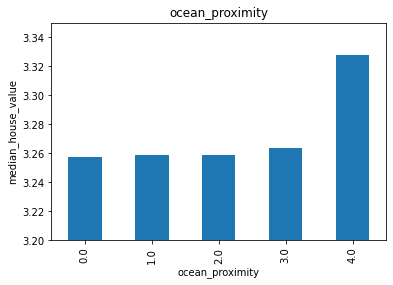

In [34]:
# CHecking the monotonic relationship between labels and target
def analyse_vars(train, y_train, var):
    # function plots median house sale price per encoded
    # category
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['median_house_value'].median().plot.bar()
    plt.title(var)
    plt.ylim(3.2, 3.35)
    plt.ylabel('median_house_value')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

 The monotonic relationship shows, though not very clearly. It does appear that the higher the integer that represents the category, the higher the mean house sale price. Target has been transformed, hence the differences are small.
 
## Feature Scaling

We now need to scale the features for use in a linear model. We shall use Standard Scaling for this task

In [35]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [36]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity,income_bracket,rooms_per_household,bedrooms_per_household,population_per_household,median_income_per_household
0,-1.372821,0.894943,1.859559,0.211547,-0.434088,1.887371,2.032736,1.692556,1.080911,-0.106259,0.086694,-0.026318
1,0.657329,-0.780212,0.987199,-1.494151,-0.672195,-1.391316,-0.897604,-0.508495,-0.943396,-0.106259,0.086694,-0.026318
2,0.772055,-0.719382,1.225115,-0.125347,-0.366916,1.398167,0.079176,1.692556,1.080911,-0.106259,0.086694,-0.026318
3,-1.302988,0.815397,0.114838,0.248200,-0.282584,2.308039,2.032736,3.893607,1.515660,-0.106259,0.086694,-0.026318
4,1.166114,-1.065644,-0.916133,-0.418663,-0.212792,-1.089247,-0.897604,-0.508495,-0.943396,-0.106259,0.086694,-0.026318


In [37]:
# Saving the train and test sets for the next notebook

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)

In [38]:
# now let's save the scaler

joblib.dump(scaler, 'standard_scaler.joblib') 

['standard_scaler.joblib']

Here concludes the Feature Engineering notebook